<center><h1>2-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>



In [9]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2022-11-18 20:58:38--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2022-11-18 20:58:38--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2022-11-18 20:58:38 (25.2 MB/s) - ‘utils.py’ saved [2627/2627]



In [10]:
%run 'utils.py'

In [11]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

# Provided MNIST Code

In [4]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_MNIST_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
     Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0 and (i != 0 or optimizer is None):
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def MNIST_main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_MNIST_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

=== EPOCH 1 =====

[TRAIN Batch 200/469]	Time 0.017s (0.023s)	Loss 0.3419 (1.2245)	Prec@1  92.2 ( 66.3)	Prec@5 100.0 ( 92.1)


<Figure size 432x288 with 0 Axes>

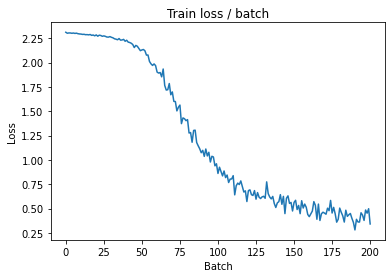

[TRAIN Batch 400/469]	Time 0.025s (0.018s)	Loss 0.1406 (0.7471)	Prec@1  94.5 ( 79.3)	Prec@5 100.0 ( 95.9)


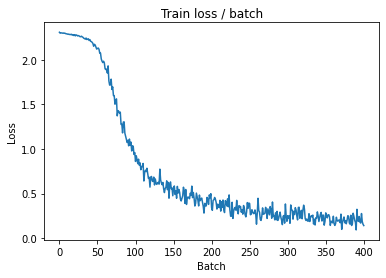


===============> Total time 8s	Avg loss 0.6656	Avg Prec@1 81.56 %	Avg Prec@5 96.45 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 0.0905 (0.0905)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.1544	Avg Prec@1 95.38 %	Avg Prec@5 99.87 %



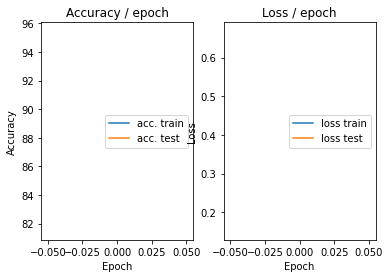

=== EPOCH 2 =====

[TRAIN Batch 200/469]	Time 0.012s (0.022s)	Loss 0.0785 (0.1458)	Prec@1  98.4 ( 95.8)	Prec@5 100.0 ( 99.9)


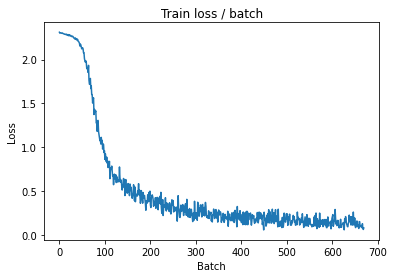

[TRAIN Batch 400/469]	Time 0.014s (0.022s)	Loss 0.0885 (0.1299)	Prec@1  97.7 ( 96.1)	Prec@5 100.0 ( 99.9)


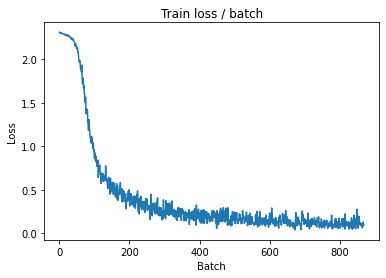


===============> Total time 10s	Avg loss 0.1245	Avg Prec@1 96.30 %	Avg Prec@5 99.90 %

[EVAL Batch 000/079]	Time 0.258s (0.258s)	Loss 0.0360 (0.0360)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0819	Avg Prec@1 97.47 %	Avg Prec@5 99.98 %



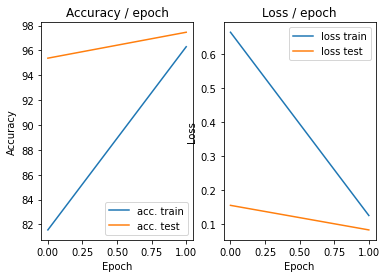

=== EPOCH 3 =====

[TRAIN Batch 200/469]	Time 0.023s (0.020s)	Loss 0.0806 (0.0877)	Prec@1  98.4 ( 97.4)	Prec@5 100.0 ( 99.9)


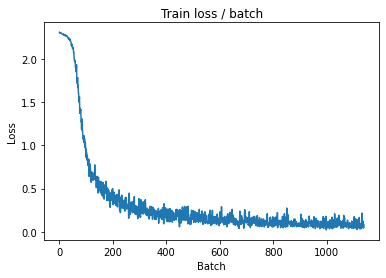

[TRAIN Batch 400/469]	Time 0.011s (0.017s)	Loss 0.0511 (0.0827)	Prec@1  98.4 ( 97.6)	Prec@5 100.0 ( 99.9)


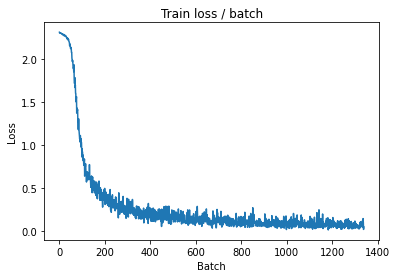


===============> Total time 7s	Avg loss 0.0820	Avg Prec@1 97.57 %	Avg Prec@5 99.95 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 0.0202 (0.0202)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0636	Avg Prec@1 97.93 %	Avg Prec@5 99.99 %



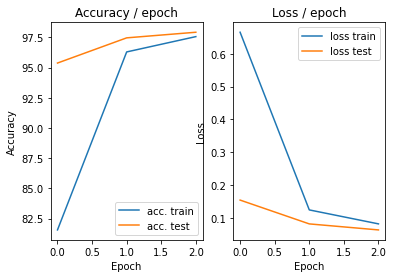

=== EPOCH 4 =====

[TRAIN Batch 200/469]	Time 0.004s (0.014s)	Loss 0.0874 (0.0672)	Prec@1  97.7 ( 98.0)	Prec@5 100.0 (100.0)


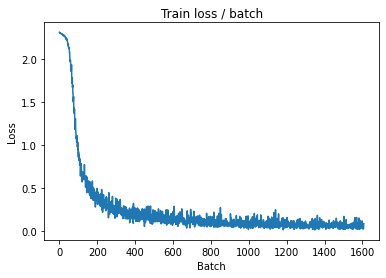

[TRAIN Batch 400/469]	Time 0.022s (0.014s)	Loss 0.0625 (0.0643)	Prec@1  98.4 ( 98.1)	Prec@5 100.0 (100.0)


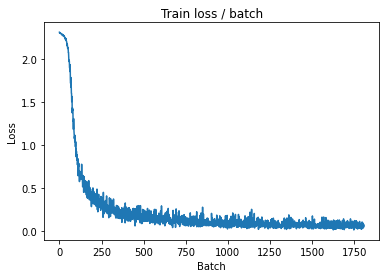


===============> Total time 6s	Avg loss 0.0638	Avg Prec@1 98.08 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 0.0139 (0.0139)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0492	Avg Prec@1 98.46 %	Avg Prec@5 99.99 %



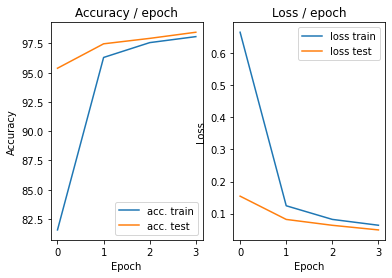

=== EPOCH 5 =====

[TRAIN Batch 200/469]	Time 0.025s (0.015s)	Loss 0.0519 (0.0551)	Prec@1  98.4 ( 98.3)	Prec@5 100.0 (100.0)


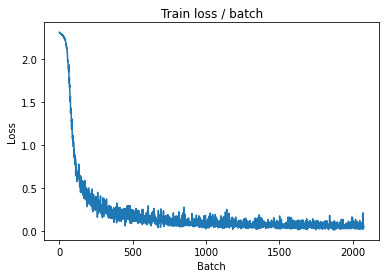

[TRAIN Batch 400/469]	Time 0.017s (0.014s)	Loss 0.0633 (0.0535)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


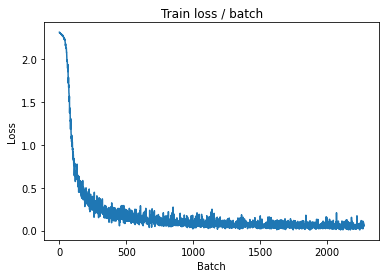


===============> Total time 6s	Avg loss 0.0533	Avg Prec@1 98.41 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 0.0112 (0.0112)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0452	Avg Prec@1 98.63 %	Avg Prec@5 99.99 %



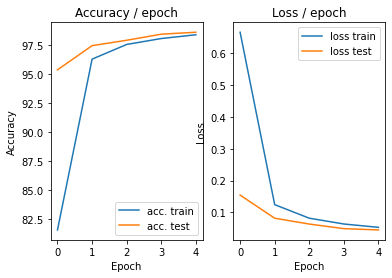

In [5]:
MNIST_main(128, 0.1, cuda=True)

# Experimentation on CIFAR-10 datasets

In [ ]:
class MyAlexNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(MyAlexNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output


def get_CIFAR_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def CIFAR_main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    torch.manual_seed(0)
    model = MyAlexNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_CIFAR_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    acc_train_list = []
    acc_test_list = []
    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        acc_train_list.append(top1_acc.avg)
        acc_test_list.append(top1_acc_test.avg)

    return acc_train_list, acc_test_list

original_acc_train, original_acc_test = CIFAR_main(128, 0.03, epochs=50, cuda=True)

# Results Improvements
## Standardization

In [7]:
def get_CIFAR_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
    ])

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
                                     transform=preprocessing)
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
                                   transform=preprocessing)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

std_acc_train, std_acc_test = CIFAR_main(128, 0.03, epochs=50, cuda=True)

Output hidden; open in https://colab.research.google.com to view.

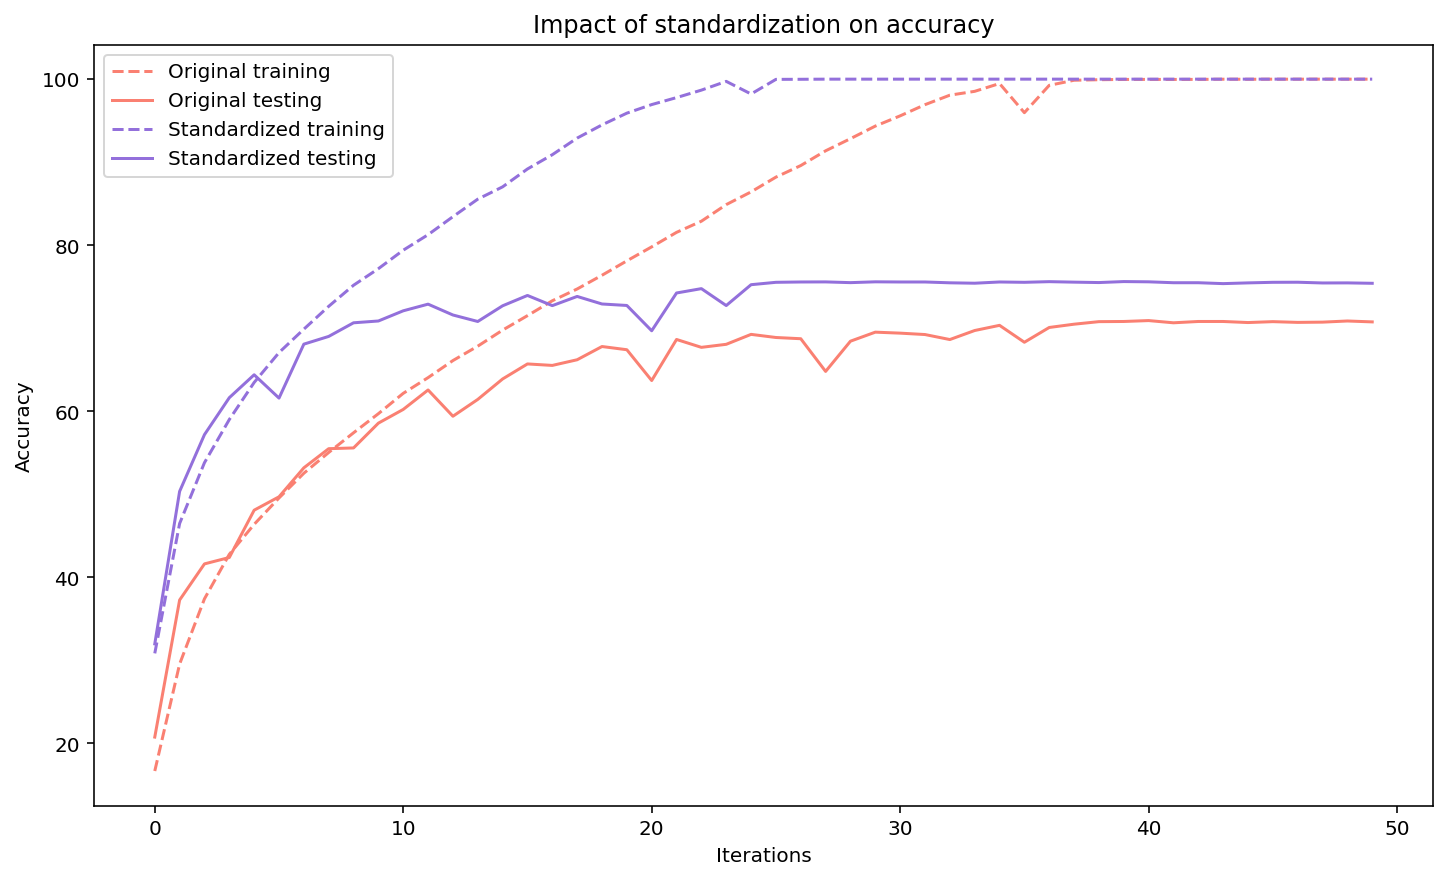

In [23]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

plt.figure(figsize=(12, 7))
plt.title("Impact of standardization on accuracy")
plt.plot(original_acc_train, "--", color="salmon", label="Original training")
plt.plot(original_acc_test, color="salmon", label="Original testing")
plt.plot(std_acc_train, "--", color="mediumpurple", label="Standardized training")
plt.plot(std_acc_test, color="mediumpurple", label="Standardized testing")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend();

## Data augmentation

In [21]:
class MyAlexNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(MyAlexNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

def get_CIFAR_dataset(batch_size, cuda=False): # TODO
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop((28, 28))
        ])
    )
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
            transforms.CenterCrop((28, 28))
        ])
    )

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


data_augmented_acc_train, data_augmented_acc_test = CIFAR_main(128, 0.03, epochs=50, cuda=True)

Output hidden; open in https://colab.research.google.com to view.

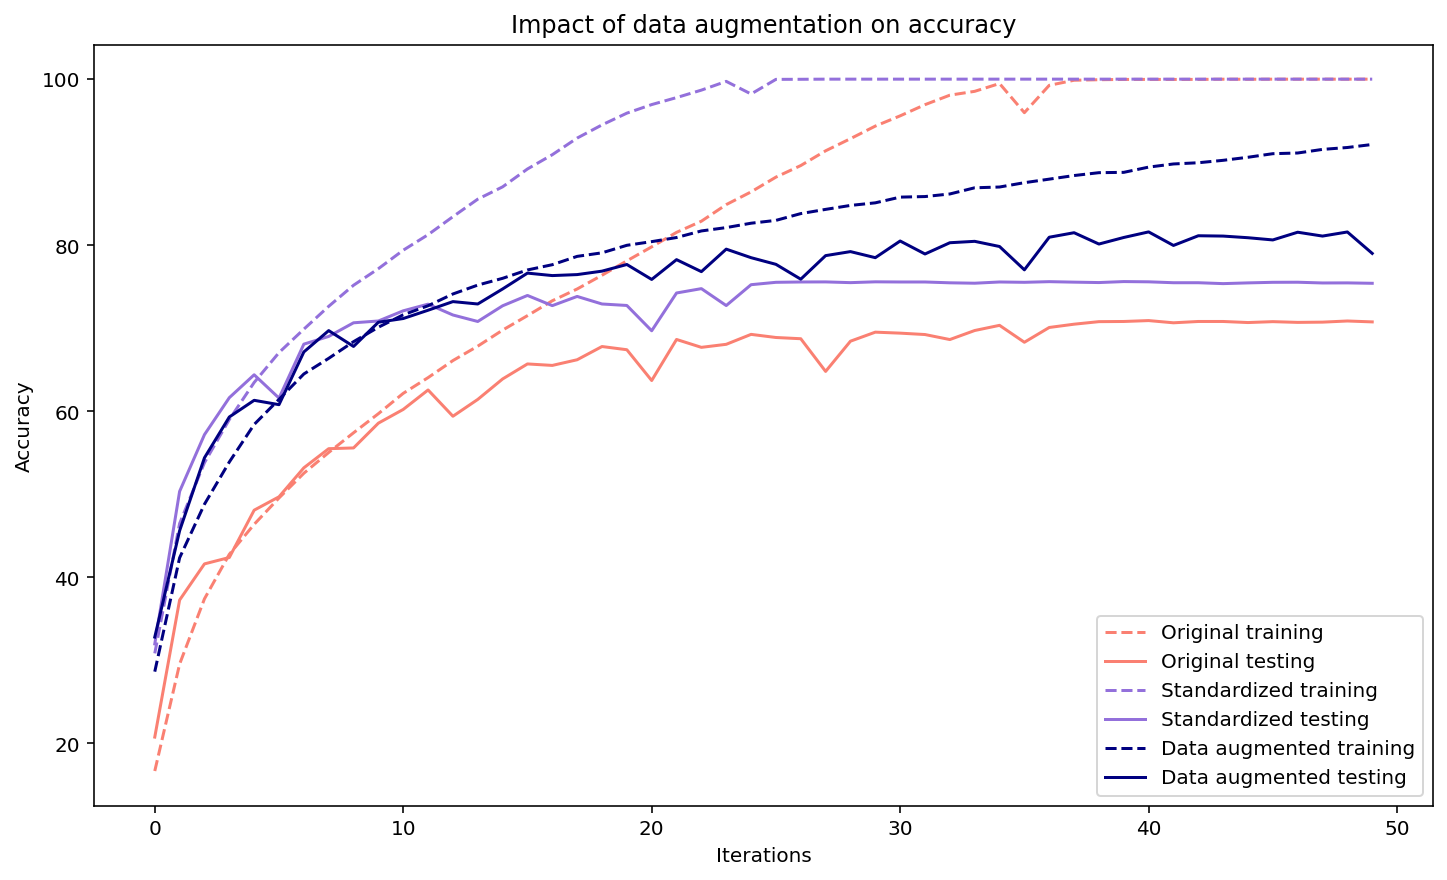

In [34]:
plt.figure(figsize=(12, 7))
plt.title("Impact of data augmentation on accuracy")
plt.plot(original_acc_train, "--", color="salmon", label="Original training")
plt.plot(original_acc_test, color="salmon", label="Original testing")
plt.plot(std_acc_train, "--", color="mediumpurple", label="Standardized training")
plt.plot(std_acc_test, color="mediumpurple", label="Standardized testing")
plt.plot(data_augmented_acc_train, "--", color="navy", label="Data augmented training")
plt.plot(data_augmented_acc_test, color="navy", label="Data augmented testing")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend();

## Learning rate scheduler

In [25]:
def CIFAR_main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    torch.manual_seed(0)
    model = MyAlexNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_CIFAR_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    acc_train_list = []
    acc_test_list = []
    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        lr_sched.step()
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        acc_train_list.append(top1_acc.avg)
        acc_test_list.append(top1_acc_test.avg)

    return acc_train_list, acc_test_list
    
lr_scheduler_acc_train, lr_scheduler_acc_test = CIFAR_main(128, 0.03, epochs=50, cuda=True)

Output hidden; open in https://colab.research.google.com to view.

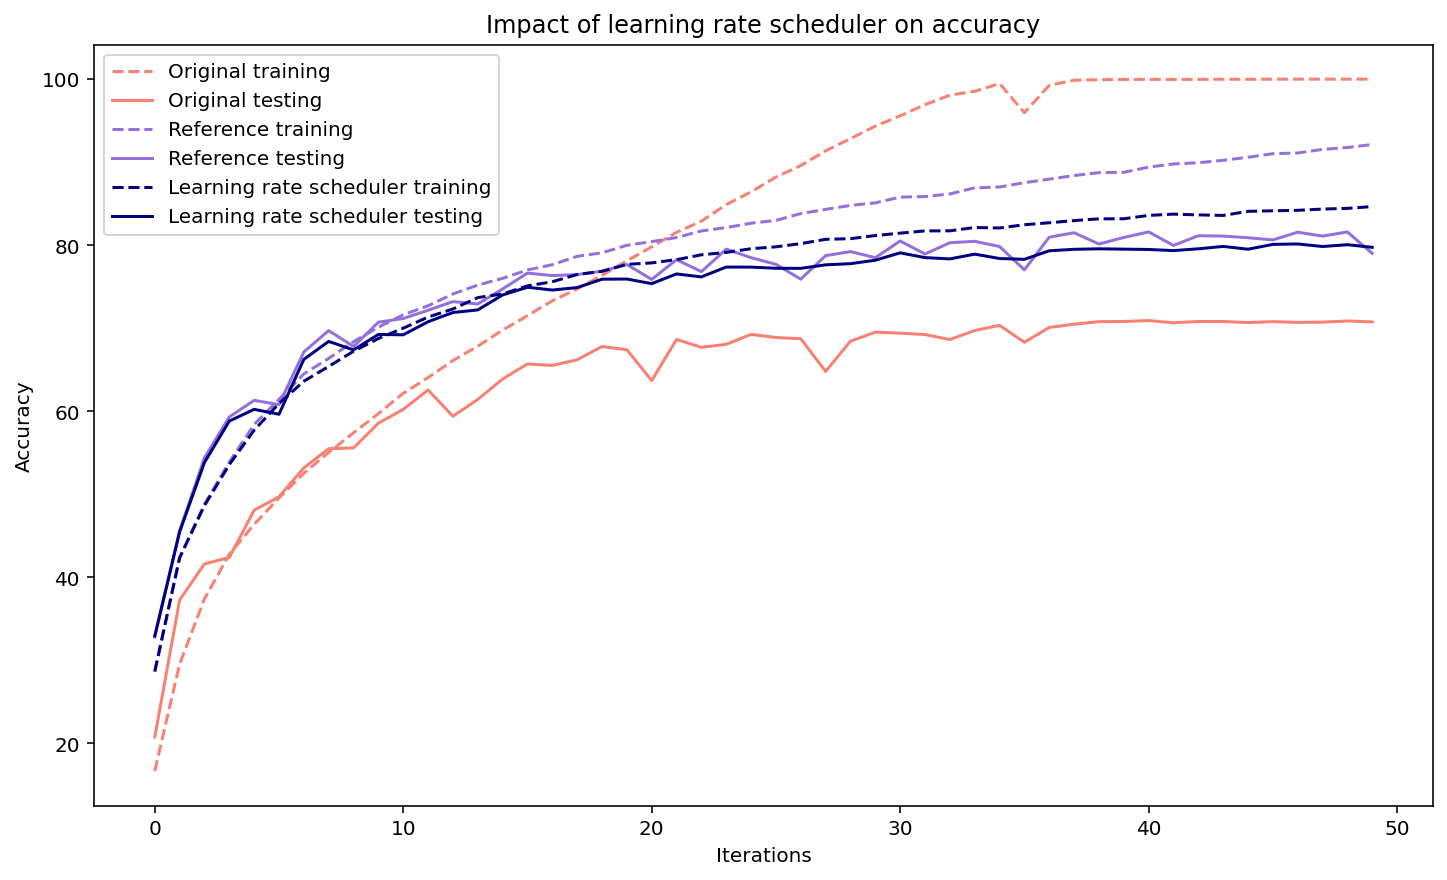

In [33]:
plt.figure(figsize=(12, 7))
plt.title("Impact of learning rate scheduler on accuracy")
plt.plot(original_acc_train, "--", color="salmon", label="Original training")
plt.plot(original_acc_test, color="salmon", label="Original testing")
plt.plot(data_augmented_acc_train, "--", color="mediumpurple", label="Reference training")
plt.plot(data_augmented_acc_test, color="mediumpurple", label="Reference testing")
plt.plot(lr_scheduler_acc_train, "--", color="navy", label="Learning rate scheduler training")
plt.plot(lr_scheduler_acc_test, color="navy", label="Learning rate scheduler testing")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend();

## Dropout

In [30]:
class MyAlexNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, dropout_rate: float = 0):
        super(MyAlexNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.Dropout(p = dropout_rate),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

def CIFAR_main(batch_size=128, lr=0.1, epochs=5, cuda=False, dropout_rate=0):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    torch.manual_seed(0)
    model = MyAlexNet(dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_CIFAR_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    acc_train_list = []
    acc_test_list = []
    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        lr_sched.step()
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        acc_train_list.append(top1_acc.avg)
        acc_test_list.append(top1_acc_test.avg)

    return acc_train_list, acc_test_list
    

dropout25_acc_train, dropout25_acc_test = CIFAR_main(128, 0.03, epochs=50, cuda=True, dropout_rate=0.25)
dropout50_acc_train, dropout50_acc_test = CIFAR_main(128, 0.03, epochs=50, cuda=True, dropout_rate=0.5)
dropout75_acc_train, dropout75_acc_test = CIFAR_main(128, 0.03, epochs=50, cuda=True, dropout_rate=0.75)

Output hidden; open in https://colab.research.google.com to view.

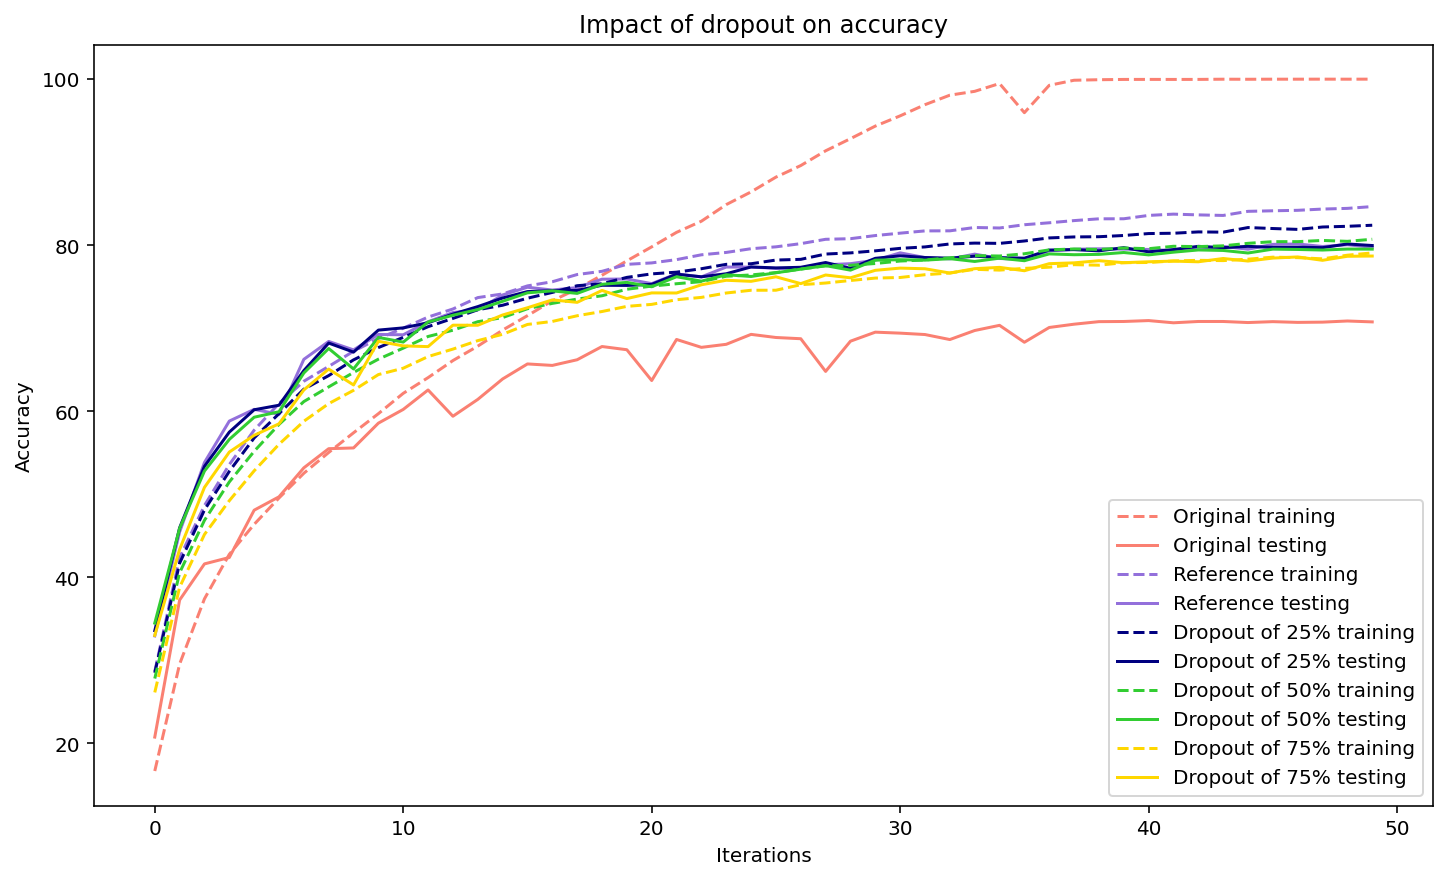

In [32]:
plt.figure(figsize=(12, 7))
plt.title("Impact of dropout on accuracy")
plt.plot(original_acc_train, "--", color="salmon", label="Original training")
plt.plot(original_acc_test, color="salmon", label="Original testing")
plt.plot(lr_scheduler_acc_train, "--", color="mediumpurple", label="Reference training")
plt.plot(lr_scheduler_acc_test, color="mediumpurple", label="Reference testing")

plt.plot(dropout25_acc_train, "--", color="navy", label="Dropout of 25% training")
plt.plot(dropout25_acc_test, color="navy", label="Dropout of 25% testing")

plt.plot(dropout50_acc_train, "--", color="limegreen", label="Dropout of 50% training")
plt.plot(dropout50_acc_test, color="limegreen", label="Dropout of 50% testing")

plt.plot(dropout75_acc_train, "--", color="gold", label="Dropout of 75% training")
plt.plot(dropout75_acc_test, color="gold", label="Dropout of 75% testing")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend();

## Batch Normalization

In [ ]:
class MyAlexNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, dropout_rate: float = 0):
        super(MyAlexNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output


batch_norm_acc_train, batch_norm_acc_test = CIFAR_main(128, 0.03, epochs=50, cuda=True)

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Impact of batch normalization on accuracy")
plt.plot(original_acc_train, "--", color="salmon", label="Original training")
plt.plot(original_acc_test, color="salmon", label="Original testing")
plt.plot(lr_scheduler_acc_train, "--", color="mediumpurple", label="Reference training")
plt.plot(lr_scheduler_acc_test, color="mediumpurple", label="Reference testing")

plt.plot(batch_norm_acc_train, "--", color="navy", label="Batch normlization training")
plt.plot(batch_norm_acc_test, color="navy", label="Batch normlization testing")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend();